 # Machine Learning and Predictive Modeling - Assignment 4
 ### Arpit Parihar
 ### 04/26/2021
 ****

 **Importing modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pretty_cm import pretty_plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc, plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier as XGBClassifier
import warnings
warnings.filterwarnings('ignore')

 ### 1\. Data Processing

In [2]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
        'marital_status', 'occupation', 'relationship', 'race', 'sex',
        'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'salary']
adult_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None, names=cols, skipinitialspace=True)
adult_df.shape

(32561, 15)

In [3]:
adult_df.drop(columns='fnlwgt', inplace=True)
adult_df.salary.replace({'<=50K': 0, '>50K': 1}, inplace=True)


In [4]:
X = adult_df.drop(columns='salary')
print(f'Shape of X = {X.shape}')
y = adult_df.salary
print(f'Shape of y = {y.shape}')

Shape of X = (32561, 13)
Shape of y = (32561,)


In [5]:
X_encoded = pd.get_dummies(X)
print(f'Shape of X_encoded = {X_encoded.shape}')

Shape of X_encoded = (32561, 107)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, random_state=7, test_size=0.3)
X_train.shape[1] == X_test.shape[1]

True

 ### Creating functions to fit models and create performance reports

In [7]:


class color:    # class to format print statements
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


# function to print classification results
def classification_results(act, pred, prob, header=None):
    labels = ['<=50', '>50']
    print(color.UNDERLINE + color.BOLD + header + ':\n' + color.END)
    print('Confusion Matrix:\n')
    plt.pause(1)
    pretty_plot_confusion_matrix(pd.DataFrame(confusion_matrix(
        act, pred), columns=labels, index=labels), pred_val_axis='x')
    plt.show()
    print('\n' + '-' * 75 + '\n')
    print(classification_report(act, pred, digits=4))
    print('\n' + '-' * 75 + '\n')
    print('AUROC: %2.2f%%' % (100 * roc_auc_score(act, prob)))
    print('\n' + '-' * 75 + '\n')
    precision, recall, thresholds = precision_recall_curve(act, prob)
    print('AUPRC: %2.2f%%' % (100 * auc(recall, precision)))
    print('\n')

# function to plot feature importance plot


def feature_importance_plot(cols, imp, title=''):
    print(color.UNDERLINE + color.BOLD + title +
          ' Feature Importance Plot:\n' + color.END)
    fi = sorted(list(imp), reverse=True)[:10]
    cols = [x for _, x in sorted(
        zip(imp, cols), reverse=True)][:10]
    fi_plot = sns.barplot(fi, cols)
    plt.ylabel('Features')
    # plt.xticks(rotation=90)
    plt.xlabel('Importance')
    plt.title(title + ' Feature Importance Plot')
    plt.show(fi_plot);
    print('\n')

# function to fit tuned/untuned models and print performance reports


def model_fit_and_report(X_train, X_test, y_train, y_test, base, title, tuned=False, method='grid', cv=None, param_grid=None, save_as=None):
    assert method in ['grid', 'random'], \
        f'Invalid "method" parameter, "{method}". It should be either "grid" or "random".'
    try:
        model = joblib.load(save_as)
        model_best = model.best_estimator_ if tuned else model
    except:
        if tuned:
            if method == 'grid':
                model = GridSearchCV(
                    base, param_grid, cv=cv,
                    scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)
            elif method == 'random':
                model = RandomizedSearchCV(
                    base, param_grid, cv=cv,
                    scoring='roc_auc', refit=True, n_jobs=-1, verbose=5)

        else:
            model = base
        model.fit(X_train, y_train)
        model_best = model.best_estimator_ if tuned else model

    if save_as: joblib.dump(model, save_as)

    feature_importance_plot(
        X_train.columns, model_best.feature_importances_, title)
    y_pred = model_best.predict(X_test)
    y_prob = model_best.predict_proba(X_test)[:, 1]
    y_pred_tr = model_best.predict(X_train)
    y_prob_tr = model_best.predict_proba(X_train)[:, 1]

    classification_results(y_test, y_pred, y_prob,
                           title + ' Test Performance')
    classification_results(y_train, y_pred_tr, y_prob_tr,
                           title + ' Train Performance')

    return model



 ### 2\. Random Forest Classifier - Base Model:

Base RF Feature Importance Plot:



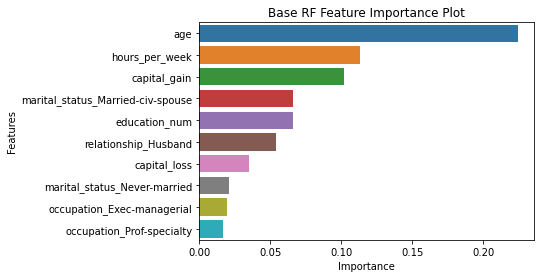



Base RF Test Performance:

Confusion Matrix:



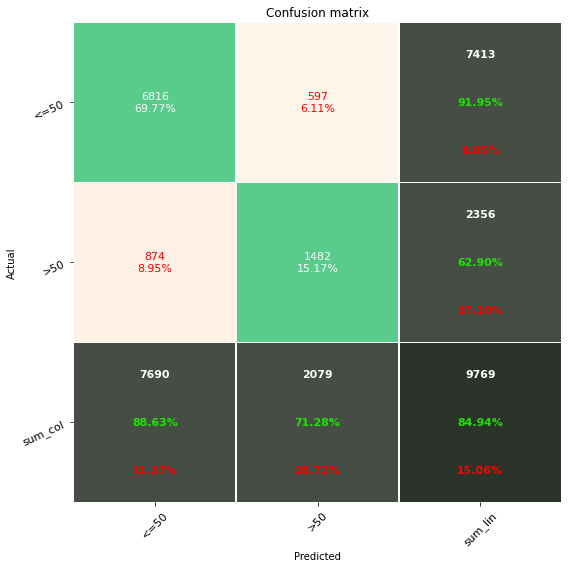


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8863    0.9195    0.9026      7413
           1     0.7128    0.6290    0.6683      2356

    accuracy                         0.8494      9769
   macro avg     0.7996    0.7742    0.7855      9769
weighted avg     0.8445    0.8494    0.8461      9769


---------------------------------------------------------------------------

AUROC: 89.20%

---------------------------------------------------------------------------

AUPRC: 74.17%


Base RF Train Performance:

Confusion Matrix:



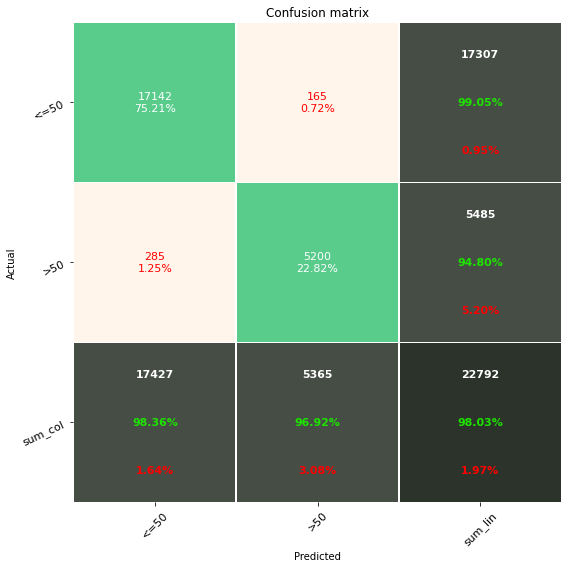


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.9836    0.9905    0.9870     17307
           1     0.9692    0.9480    0.9585      5485

    accuracy                         0.9803     22792
   macro avg     0.9764    0.9693    0.9728     22792
weighted avg     0.9802    0.9803    0.9802     22792


---------------------------------------------------------------------------

AUROC: 99.79%

---------------------------------------------------------------------------

AUPRC: 99.39%




In [8]:
rf_base = model_fit_and_report(
    X_train, X_test, y_train, y_test,
    base=RandomForestClassifier(random_state=7),
    title='Base RF')

 The base random forest model is overfitting as there is a huge gap in performance between train and test data

 ### 3\. AdaBoost Classifier - GridSearch:

AdaBoost Feature Importance Plot:



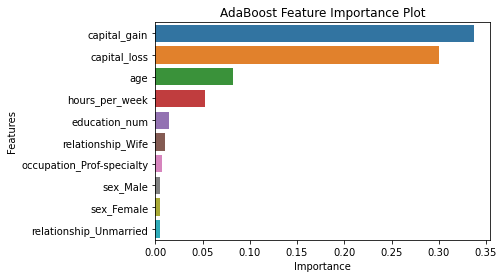



AdaBoost Test Performance:

Confusion Matrix:



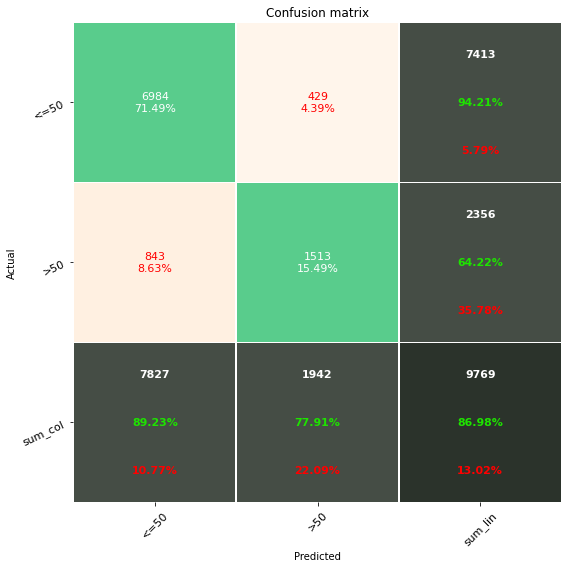


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8923    0.9421    0.9165      7413
           1     0.7791    0.6422    0.7040      2356

    accuracy                         0.8698      9769
   macro avg     0.8357    0.7922    0.8103      9769
weighted avg     0.8650    0.8698    0.8653      9769


---------------------------------------------------------------------------

AUROC: 92.76%

---------------------------------------------------------------------------

AUPRC: 82.48%


AdaBoost Train Performance:

Confusion Matrix:



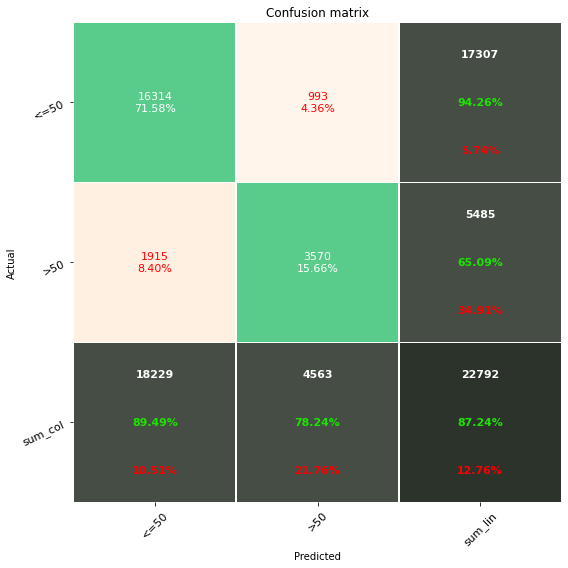


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8949    0.9426    0.9182     17307
           1     0.7824    0.6509    0.7106      5485

    accuracy                         0.8724     22792
   macro avg     0.8387    0.7967    0.8144     22792
weighted avg     0.8679    0.8724    0.8682     22792


---------------------------------------------------------------------------

AUROC: 93.08%

---------------------------------------------------------------------------

AUPRC: 83.26%




In [9]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2]}

ada_tuned = model_fit_and_report(
    X_train, X_test, y_train, y_test,
    base=AdaBoostClassifier(random_state=7),
    title='AdaBoost',
    tuned=True,
    cv=5,
    param_grid=param_grid,
    save_as='ada_tuned.pkl')

 The train and test performance are comparable for AdaBoost, and the model is not overfitting

 ### 4\. Gradient Boosting Classifier - GridSearch:

Gradient Boost Feature Importance Plot:



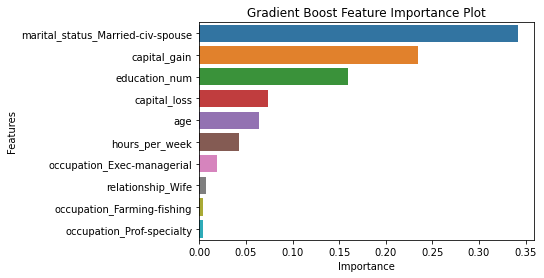



Gradient Boost Test Performance:

Confusion Matrix:



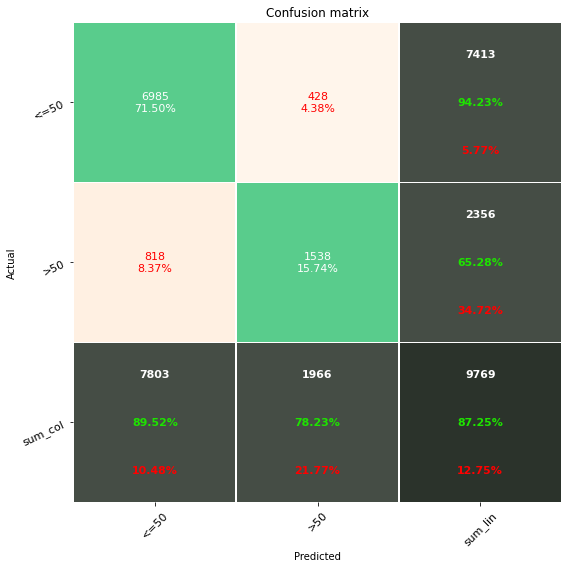


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8952    0.9423    0.9181      7413
           1     0.7823    0.6528    0.7117      2356

    accuracy                         0.8725      9769
   macro avg     0.8387    0.7975    0.8149      9769
weighted avg     0.8679    0.8725    0.8683      9769


---------------------------------------------------------------------------

AUROC: 93.02%

---------------------------------------------------------------------------

AUPRC: 82.86%


Gradient Boost Train Performance:

Confusion Matrix:



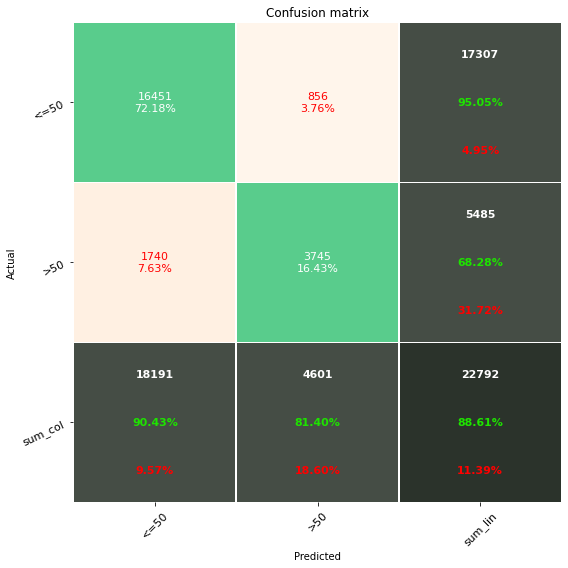


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.9043    0.9505    0.9269     17307
           1     0.8140    0.6828    0.7426      5485

    accuracy                         0.8861     22792
   macro avg     0.8592    0.8167    0.8347     22792
weighted avg     0.8826    0.8861    0.8825     22792


---------------------------------------------------------------------------

AUROC: 94.23%

---------------------------------------------------------------------------

AUPRC: 85.89%




In [10]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.4, 0.5, 0.6],
    'max_depth': [1, 2]}

gbm_tuned = model_fit_and_report(
    X_train, X_test, y_train, y_test,
    base=GradientBoostingClassifier(random_state=7),
    title='Gradient Boost',
    tuned=True,
    cv=5,
    param_grid=param_grid,
    save_as='gbm_tuned.pkl')

 The train and test performance are almost the same for gradient boost, and the model is not overfitting

 ### 5\. XGBoost - RandomizedSearchCV

XGBoost Feature Importance Plot:



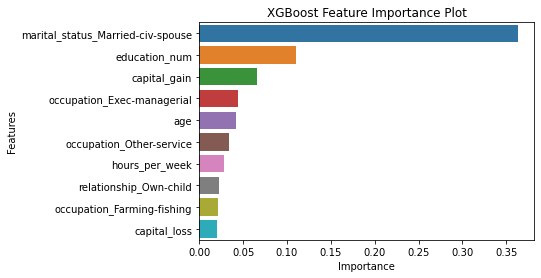



XGBoost Test Performance:

Confusion Matrix:



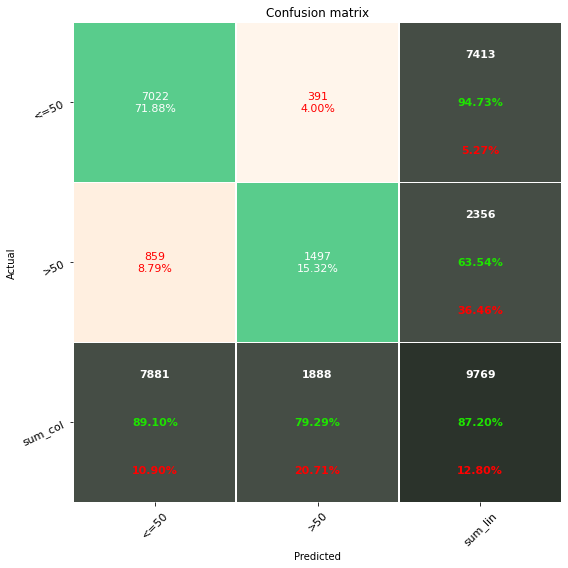


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8910    0.9473    0.9183      7413
           1     0.7929    0.6354    0.7055      2356

    accuracy                         0.8720      9769
   macro avg     0.8420    0.7913    0.8119      9769
weighted avg     0.8673    0.8720    0.8669      9769


---------------------------------------------------------------------------

AUROC: 92.82%

---------------------------------------------------------------------------

AUPRC: 82.72%


XGBoost Train Performance:

Confusion Matrix:



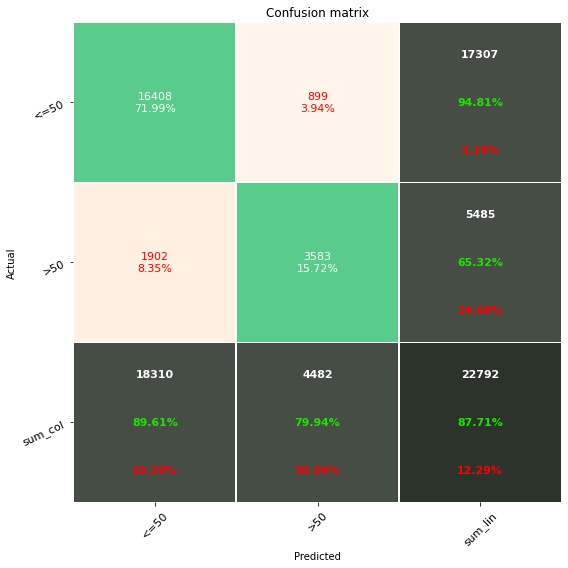


---------------------------------------------------------------------------

              precision    recall  f1-score   support

           0     0.8961    0.9481    0.9214     17307
           1     0.7994    0.6532    0.7190      5485

    accuracy                         0.8771     22792
   macro avg     0.8478    0.8006    0.8202     22792
weighted avg     0.8729    0.8771    0.8727     22792


---------------------------------------------------------------------------

AUROC: 93.28%

---------------------------------------------------------------------------

AUPRC: 83.73%




In [11]:
param_grid = {
    'n_estimators': np.arange(100, 1000 + 50, 50).tolist(),
    'learning_rate': np.arange(0.1, 1.6 + 0.1, 0.1).tolist(),
    'max_depth': [1, 2],
    'gamma': np.arange(0, 5 + 0.25, 0.25).tolist()}

xgb_tuned = model_fit_and_report(
    X_train, X_test, y_train, y_test,
    base=XGBClassifier(random_state=7),
    title='XGBoost',
    tuned=True,
    method='random',
    cv=5,
    param_grid=param_grid,
    save_as='xgb_tuned.pkl')

 The train and test performance are very close for xgboost as well, and the model is not overfitting

 ### 6\. Moving into Conceptual Problems:

 **a) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.**
 alpha is the weight or "amount of say" each tree gets in the final prediction. Each tree has different contribution towards the final output, and this is one of the ways in which AdaBoost differs from Gradient Boost, in which, each tree has the same contribution, which is shrinkage, or the learning rate.

 **b) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.**

 In AdaBoost, final output is the sum of log-odds predicted by each tree, weighted by their importance, alpha. This final log-odds is converted to a probability, and a threshold is applied to it to get the class prediction. Another approach to make final predictions, which is used by default in sklearn is to take a vote of predictions, weighted by tree importance, or alpha.

 **c) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?**

 The core concept of boosting is to combine several "weak learners" to create a strong final model. If max_depth is too high, the trees will grow deep, and will no longer be "weak learners". Deep trees tend to overfit the training data, which means the residuals get smaller, which leaves little room for improvement for subsequent trees. A small learning rate counters this problem by diminishing the effect of each tree, but it's still preferable to have a smaller max_depth so that each tree can contribute a decent amount towards improving the model.

 **d) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).**

 Age, an number of years of education show up in the top 5 o all the 4 models, which makes sense intuitively, as salaries go up with age, and with the years of education one has. To verify this, let's observe the plots below:


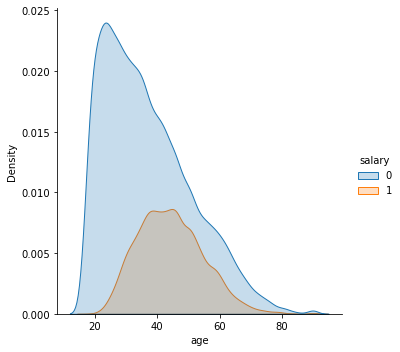

In [12]:
sns.displot(adult_df, x='age', hue='salary',
            kind='kde', fill=True, bw_adjust=0.9);

 It can be seen from the plot that employees with annual salary higher than 50K are in their mid-career, with average age being around 40, while those with annual salary less than 50K have average age around 25.


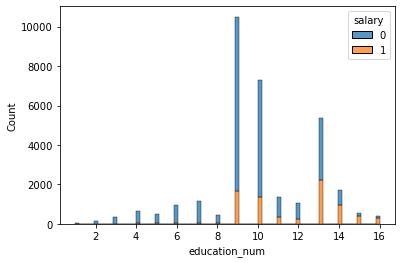

In [13]:
sns.histplot(adult_df, x='education_num', hue='salary', multiple='stack');

 It can again be verified from the plot that people with more education have higher salaries, as the share of orange goes up with years of education.


 **e) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.**

 Based on test performance, gradient boost from sklearn performs the best. It has the highest AUROC (0.9302), highest F-1 score for the minority class (0.71) and highest AUPRC (0.8286), the latter 2 of which indicate good performance with imbalanced data. The best parameters for the model are:


In [14]:
print(color.BOLD + color.UNDERLINE + f'Best parameters for gradient boost:' +
      color.END + f'\n\n{gbm_tuned.best_params_}')

Best parameters for gradient boost:

{'learning_rate': 0.4, 'max_depth': 2, 'n_estimators': 400}


 **f) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.**


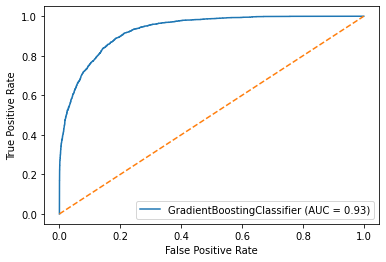

In [15]:
plot_roc_curve(gbm_tuned.best_estimator_, X_test, y_test);
plt.plot([0.01 * x for x in range(101)],
         [0.01 * x for x in range(101)], linestyle='--');

 As threshold is lowered, the x-axis tells how many false positives are observed, while y-axis tells how many true positives are captured. The "ideal" classifier has a straight vertical line at x = 0, followed by a straight horizontal line at y = 1, which means that at some threshold, all the true positives are captured with 0 false positives. The area under this curve is 1. Good classifiers have their vertex as close to top left as possible, which implies that a good threshold will capture most true positives with very few false positives.
